In [1]:
import pennylane as qml 
from pennylane import numpy as np 
import numpy as scinp 
import matplotlib.pyplot as plt 
plt.rcParams['figure.figsize'] = [10, 10]
import torch
from torch.nn.init import xavier_uniform_
from torch import nn 

# We create some toy data to test the anomaly detection algorithm .

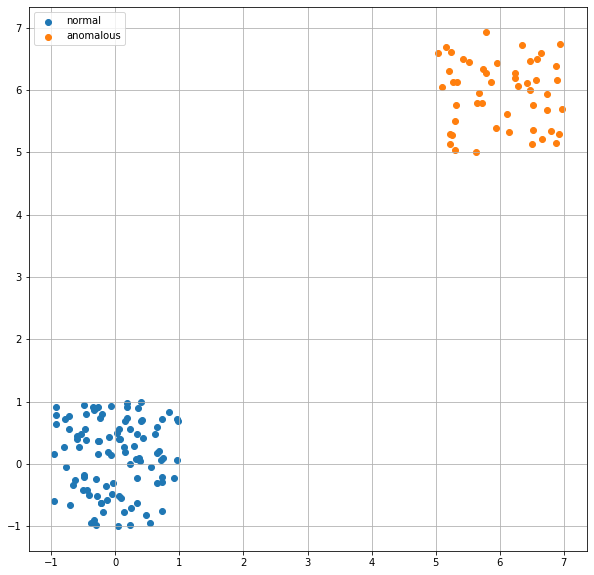

In [2]:
fig,ax=plt.subplots()
X_normal=scinp.random.uniform(low=-1,high=1,size=(100,2))
y_normal=scinp.ones(100)
X_anomalous=scinp.random.uniform(low=3,high=5,size=(50,2))+2
y_anomalous=scinp.ones(50)*-1
plt.scatter(X_normal[:,0],X_normal[:,1],label='normal')
plt.scatter(X_anomalous[:,0],X_anomalous[:,1],label='anomalous')
ax.legend()
ax.grid(True)
plt.show()

# We now code up the quantum generator in the algorithm. To do this, we need to create three separate functions: 
# (1) The state preparation function. This takes in N latent variables, and encodes them in a quantum state using N single qubit Rx rotations on each latent variable.
# (2) The variational circuit function. This function first encodes the data using the state preparation function, and then applies layers of qubit operations, with the layers consisting of single qubit rotations sampled uniformly from the {Rx,Ry,Rz} rotations, and CNOT gates. At the end of the variational circuit, every qubit is measured using the Pauli Z observables.
# (3) The classical upscaling layer. This function simply appends a layer to the variational circuit which upscales the dimensionality of the circuit output to the dimensionality of the dataset, and it features a sigmoid activation function.

In [3]:
latent_dimensionality=2

In [280]:
dev=qml.device("qulacs.simulator",wires=latent_dimensionality,gpu=True)

In [281]:
def state_preparation(latent_variables):
    for i in range(len(latent_variables)):
        qml.RX(latent_variables[i],wires=i)

In [282]:
def layer(W):
    num_wires=len(W)
    for i in range(num_wires):
        random_rot=np.random.choice([qml.RX,qml.RY,qml.RZ])
        random_rot(W[i],wires=i)
        
    for i in range(num_wires-1):
        qml.CNOT(wires=[i,i+1])
        

In [283]:
@qml.qnode(dev,interface='torch')
def variational_circuit(latent_variables,weights):
    # The number of wires is exactly equal to 
    # the dimensionality of the latent variables.
    
    state_preparation(latent_variables)

    for W in weights:
        layer(W)
    
    return [qml.expval(qml.PauliZ(i)) for i in range(len(latent_variables))]

# We test our variational circuit by generating random variables and a glorot uniform distributed weights array, and drawing the circuit and evaluating it. 

In [284]:
latent_variables=scinp.random.uniform(-np.pi,np.pi,size=(latent_dimensionality,))
latent_variables

array([ 1.57602721, -2.8701105 ])

In [285]:
num_layers=2

In [286]:
W=torch.empty(num_layers,latent_dimensionality)
W=xavier_uniform_(W)
W

tensor([[-1.1391, -0.2466],
        [-0.1945, -1.1888]])

In [287]:
drawer=qml.draw(variational_circuit)

In [288]:
# We draw the circuit. 
variational_circuit(latent_variables,W)
print(variational_circuit.draw())

 0: ──RX(1.58)───RZ(-1.14)───╭C──RX(-0.195)──╭C──┤ ⟨Z⟩ 
 1: ──RX(-2.87)──RZ(-0.247)──╰X──RY(-1.19)───╰X──┤ ⟨Z⟩ 



In [289]:
variational_circuit(latent_variables,W)

tensor([ 0.9082, -0.5858], dtype=torch.float64)

# We have shown that the code for the variational circuit is working correctly. We can now proceed with the rest of the algorithm. 

In [290]:
# We define the Torch generator now.

In [291]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using {} device".format(device))

Using cuda:0 device


In [296]:
class QuantumGenerator(nn.Module):
    
    def __init__(self,variational_quantum_circuit,latent_dim,num_layers,upscaling_dimension):
        super(QuantumGenerator,self).__init__()
        
        self.latent_dim=latent_dim
        # We initalize and store the quantum classifier's weights
        W=torch.empty(num_layers,latent_dim)
        W=xavier_uniform_(W)
        self.quantum_weights=W
        
        # We store the quantum classifier
        self.vqc=variational_quantum_circuit
                
        # We define the upscaling layer, and we initialize it using the 
        # glorot uniform weight initialization
        self.upscaling_layer=nn.Linear(latent_dim,upscaling_dimension)
        xavier_uniform_(self.upscaling_layer.weight)
        
    def forward(self):
        # We define the latent variables, and pass them through a quantum generator.
        latent_variables=torch.Tensor(self.latent_dim).uniform_(-np.pi,np.pi).to(device)
        quantum_out=torch.Tensor(0,latent_dimensionality).to(device)
        exp_val=self.vqc(latent_variables,self.quantum_weights).float().unsqueeze(0).to(device)
        quantum_out=torch.cat((quantum_out,exp_val))
        generated_sample=self.upscaling_layer(quantum_out)
        generated_sample=quantum_out
        return generated_sample

In [297]:
quantum_gen=QuantumGenerator(variational_circuit,latent_dimensionality,num_layers,4)
quantum_gen=quantum_gen.to(device)

In [299]:
quantum_gen.forward()

tensor([[-0.4486, -0.4299]], device='cuda:0')